Install Required Libraries

In [1]:
!pip list

Package                      Version
---------------------------- --------------
absl-py                      2.1.0
anyio                        4.3.0
appnope                      0.1.4
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.2.0
Babel                        2.15.0
beautifulsoup4               4.12.3
bleach                       6.1.0
certifi                      2023.5.7
cffi                         1.16.0
charset-normalizer           3.1.0
click                        8.1.3
comm                         0.2.2
contourpy                    1.0.7
curve                        0.0.7
cycler                       0.11.0
debugpy                      1.8.1
decorator                    5.1.1
defusedxml                   0.7.1
exceptiongroup               1.2.1
executing                    2.0.1

In [2]:
!pip install opencv-python matplotlib imageio gdown tensorflow

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import gdown
import tensorflow as tf
from typing import List

2024-05-22 22:39:01.641165: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
#tf.config.list_physical_devices('GPU')

In [5]:
'''
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass
    '''

"\nphysical_devices = tf.config.list_physical_devices('GPU')\ntry:\n    tf.config.experimental.set_memory_growth(physical_devices[0], True)\nexcept:\n    pass\n    "

In [46]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=2742d3d8-2a9a-4a66-9503-4beb7c6347e5
To: /Users/wuhaoming/Documents/GitHub/LIp-Reading-App/data.zip
 29%|██▉       | 124M/423M [00:05<00:10, 29.4MB/s] 

KeyboardInterrupt: 

Data Loading

In [6]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        #only take the mouth region, could be improved by using a face detector
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    #normalize the frames
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [7]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [8]:
# char to num and num to char mappings
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

In [9]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [10]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [11]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [12]:
test_path = './data/s1/bbal6n.mpg'

In [13]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [14]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

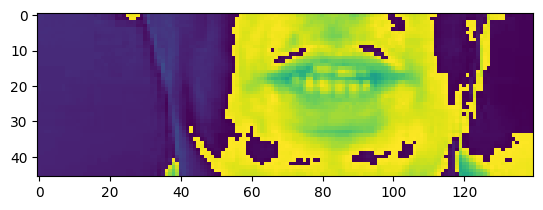

In [15]:
plt.imshow(frames[40])

In [16]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [17]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [18]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

Create Data Pipeline

In [19]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)
train = data.take(450)
test = data.skip(450)

In [20]:
len(test)

50

In [21]:
frames, alignments = data.as_numpy_iterator().next()

In [22]:
len(frames)

2

In [23]:
val = data.as_numpy_iterator().next()

In [24]:
val[0]

array([[[[[ 1.3487025 ],
          [ 1.3487025 ],
          [ 1.3487025 ],
          ...,
          [ 9.599588  ],
          [ 9.996265  ],
          [10.0359335 ]],

         [[ 1.3487025 ],
          [ 1.3487025 ],
          [ 1.3487025 ],
          ...,
          [ 9.6392565 ],
          [10.115269  ],
          [ 9.996265  ]],

         [[ 1.2693671 ],
          [ 1.2693671 ],
          [ 1.2693671 ],
          ...,
          [10.075602  ],
          [10.075602  ],
          [10.075602  ]],

         ...,

         [[ 0.991693  ],
          [ 0.991693  ],
          [ 0.991693  ],
          ...,
          [ 9.91693   ],
          [ 9.91693   ],
          [ 9.91693   ]],

         [[ 0.9520253 ],
          [ 0.9520253 ],
          [ 0.9520253 ],
          ...,
          [ 9.91693   ],
          [ 9.877263  ],
          [ 9.877263  ]],

         [[ 0.9520253 ],
          [ 0.9520253 ],
          [ 0.9520253 ],
          ...,
          [ 9.91693   ],
          [ 9.877263  ],
          

In [25]:
val[0][0].shape

(75, 46, 140, 1)

In [26]:
processed_frames = [(frame.squeeze(axis=-1)).astype(np.uint8) for frame in val[0][0]]

In [27]:
imageio.mimsave('./animation.gif', processed_frames, fps=10)

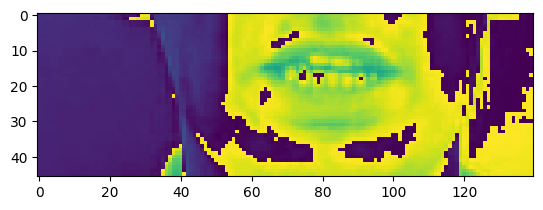

In [28]:
plt.imshow(val[0][0][35])

In [29]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set red in t eight now'>

Design the Deep Neural Network

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [31]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [32]:
model = Sequential()
model.add(Conv3D(128,3,input_shape=(75,46,140,1),padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D(pool_size=(1,2,2)))

model.add(Conv3D(256,3,padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D(pool_size=(1,2,2)))

model.add(Conv3D(75,3,padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D(pool_size=(1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer = 'orthogonal',return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, kernel_initializer = 'orthogonal',return_sequences=True)))
model.add(Dropout(0.5))

model.add(Dense(char_to_num.vocabulary_size()+1,kernel_initializer='he_normal', activation='softmax'))

/usr/local/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [35]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b"2''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''">

In [36]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b"2''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''">

In [37]:
model.input_shape

(None, 75, 46, 140, 1)

In [38]:
model.output_shape

(None, 75, 41)

Set Training Options and Train the Model

In [39]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [40]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
    input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
    label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')
    
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype='int64')
    
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [41]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self,dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self,epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for i in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][i])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[i])).numpy().decode('utf-8'))
            print('~'*100)

In [42]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [43]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint','.weights.h5'), monitor = 'loss', save_weights_only=True)

In [44]:
schedule_callback = LearningRateScheduler(scheduler)

In [45]:
example_callback = ProduceExample(test)

In [46]:
model.fit(train, validation_data = test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100


I0000 00:00:1716431995.655756 58925009 service.cc:145] XLA service 0x600003b99c00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716431995.655808 58925009 service.cc:153]   StreamExecutor device (0): Host, Default Version
2024-05-22 22:39:55.656133: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1716431995.672885 58925009 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-05-22 22:39:58.968243: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at reshape_op.h:65 : INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1
2024-05-22 22:39:58.968326: W tensorflow/core/framework/op_kernel.cc:1839]

InvalidArgumentError: Graph execution error:

Detected at node sequential_1/time_distributed_1/Reshape_10 defined at (most recent call last):
  File "/usr/local/Cellar/python@3.9/3.9.19/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/usr/local/Cellar/python@3.9/3.9.19/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code

  File "/usr/local/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/usr/local/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/usr/local/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/usr/local/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/local/Cellar/python@3.9/3.9.19/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/usr/local/Cellar/python@3.9/3.9.19/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/usr/local/Cellar/python@3.9/3.9.19/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/usr/local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/usr/local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/usr/local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/usr/local/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/usr/local/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/var/folders/2f/5mj5f6hs3613yzxsrmjfnjg40000gn/T/ipykernel_38829/1214128382.py", line 1, in <module>

  File "/usr/local/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 314, in fit

  File "/usr/local/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

  File "/usr/local/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 104, in one_step_on_data

  File "/usr/local/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/usr/local/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.9/site-packages/keras/src/layers/layer.py", line 846, in __call__

  File "/usr/local/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.9/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/usr/local/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.9/site-packages/keras/src/models/sequential.py", line 209, in call

  File "/usr/local/lib/python3.9/site-packages/keras/src/models/functional.py", line 202, in call

  File "/usr/local/lib/python3.9/site-packages/keras/src/ops/function.py", line 155, in _run_through_graph

  File "/usr/local/lib/python3.9/site-packages/keras/src/models/functional.py", line 592, in call

  File "/usr/local/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.9/site-packages/keras/src/layers/layer.py", line 846, in __call__

  File "/usr/local/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.9/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/usr/local/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.9/site-packages/keras/src/layers/rnn/time_distributed.py", line 108, in call

  File "/usr/local/lib/python3.9/site-packages/keras/src/layers/rnn/time_distributed.py", line 108, in <listcomp>

  File "/usr/local/lib/python3.9/site-packages/keras/src/layers/rnn/time_distributed.py", line 102, in step_function

  File "/usr/local/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py", line 54, in call

  File "/usr/local/lib/python3.9/site-packages/keras/src/ops/numpy.py", line 4415, in reshape

  File "/usr/local/lib/python3.9/site-packages/keras/src/backend/tensorflow/numpy.py", line 1778, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node sequential_1/time_distributed_1/Reshape_10}}]] [Op:__inference_one_step_on_iterator_29557]